Rough Work In Progress Code for Deep Learning Classification of [Cactus Aerial Images](https://www.kaggle.com/datasets/irvingvasquez/cactus-aerial-photos)

I tried many models, based on numerous examples. My model here was based on the tutorial found here:
https://keras.io/examples/vision/image_classification_from_scratch/

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [32]:
image_size = (32, 32)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "cactus_data_import",
    validation_split=0.2,
    subset="training",
    seed=1114,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "cactus_data_import",
    validation_split=0.2,
    subset="validation",
    seed=1114,
    image_size=image_size,
    batch_size=batch_size,
)

Found 21500 files belonging to 2 classes.
Using 17200 files for training.
Found 21500 files belonging to 2 classes.
Using 4300 files for validation.


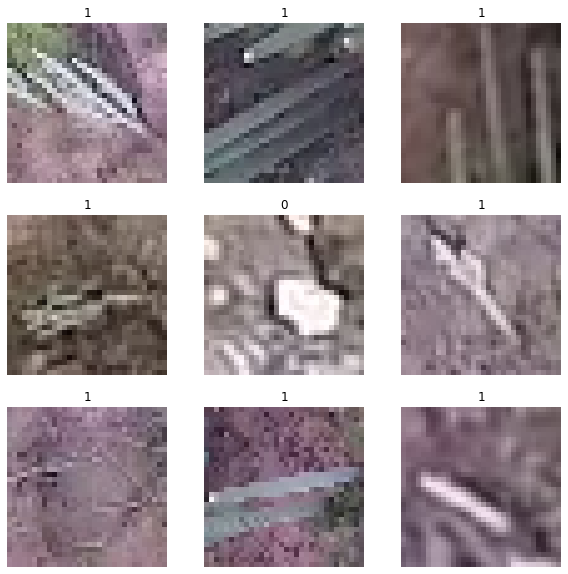

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [164]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
#    layers.RandomContrast(0.05),
#    layers.RandomBrightness((-0.05,0.05))
])

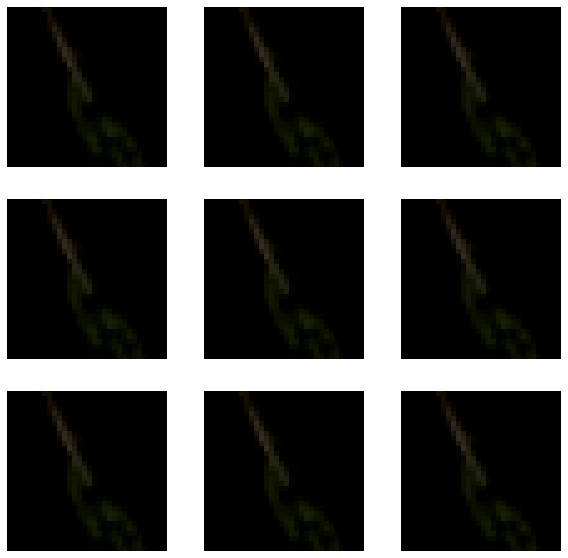

In [165]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [166]:
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [167]:
train_ds = augmented_train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [182]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same", activation = 'relu')(x)
    x = layers.BatchNormalization()(x) #Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.
    x = layers.Dropout(0.1)(x)
    x = layers.Conv2D(64, 3, padding="same", activation = 'relu')(x)
    x = layers.BatchNormalization()(x)


    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.SeparableConv2D(size, 3, padding="same", activation = 'relu')(x) #"When should we use separable convolution?" (https://ai.stackexchange.com/questions/24068/when-should-we-use-separable-convolution) : if the final output must depend of some features of one pixel and some other features of neighbors pixels in a very unpredictable way, a complete WxHxD convolution must be used. However if, as is more usual, you can handle first spatial dependencies (neighborhood) to extract pixel features and next handle pixel-by-pixel these features to get the output, better use a WxHx1 followed by 1x1xD, saving lots of network parameters, thus, saving training time.
        x = layers.BatchNormalization()(x)

        x = layers.SeparableConv2D(size, 3, padding="same", activation = 'relu')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual<-----------------Jenica check this out and understand this better. Test this!
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same", activation = 'relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.5)(x)
    x = layers.Dense(10, activation = 'relu')
    outputs = layers.Dense(1, activation = 'sigmoid')(x)#(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

TypeError: Inputs to a layer should be tensors. Got: <keras.layers.core.dense.Dense object at 0x7f84f1e66850>

In [169]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler
#-------Callbacks-------------#
best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
#    "save_at_{epoch}.h5",
    best_model_weights,
#    monitor='val_loss',
#    verbose=1,
#    save_best_only=True,
#    mode='min',
#    save_weights_only=False,
#    save_freq=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=10,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
#    batch_size=16,
    write_graph=True,
#    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.csv",
    separator = ",",
    append = False
)

#lrsched = LearningRateScheduler(step_decay,verbose=1)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [171]:
epochs = 10 #because we used more batchnormalilzation layers, we should be able to do fewer epochs

#callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
#model.fit(
#    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
#)

In [181]:
img = keras.preprocessing.image.load_img(
    "/Users/vesper/Documents/Metis/Module_6_Deep_Learning_Neural_Networks/Cactus_Classification_Dataset/test_images/U.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent likely non-cactus and %.2f percent likely a cactus."
    % (100 * (1 - score), 100 * score)
)

1/1 [==============================] - 1s 634ms/step
This image is 4.46 percent likely non-cactus and 95.54 percent likely a cactus.


In [178]:
history = model.fit(
    train_ds, 
    validation_data = val_ds,
#    steps_per_epoch  = 100, 
    epochs = 10,
    verbose = 1,
    callbacks=callbacks
)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.0851 - accuracy: 0.9691

INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


100/100 [==============================] - 27s 271ms/step - loss: 0.0851 - accuracy: 0.9691 - val_loss: 0.4103 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.1213 - accuracy: 0.9544

INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


100/100 [==============================] - 24s 241ms/step - loss: 0.1213 - accuracy: 0.9544 - val_loss: 0.2668 - val_accuracy: 0.8912 - lr: 0.0010
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.1310 - accuracy: 0.9544

INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


100/100 [==============================] - 23s 227ms/step - loss: 0.1310 - accuracy: 0.9544 - val_loss: 0.2127 - val_accuracy: 0.9165 - lr: 0.0010
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss: 0.1123 - accuracy: 0.9584

INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


100/100 [==============================] - 23s 235ms/step - loss: 0.1123 - accuracy: 0.9584 - val_loss: 0.2375 - val_accuracy: 0.9263 - lr: 0.0010
Epoch 5/10
100/100 [==============================] - ETA: 0s - loss: 0.1214 - accuracy: 0.9575

INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


100/100 [==============================] - 23s 230ms/step - loss: 0.1214 - accuracy: 0.9575 - val_loss: 0.1562 - val_accuracy: 0.9398 - lr: 0.0010
Epoch 6/10
 38/100 [==========>...................] - ETA: 8s - loss: 0.1361 - accuracy: 0.9442WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 1000 batches). You may need to use the repeat() function when building your dataset.


INFO:tensorflow:Assets written to: ./base.model/assets


INFO:tensorflow:Assets written to: ./base.model/assets


100/100 [==============================] - 14s 143ms/step - loss: 0.1361 - accuracy: 0.9442 - val_loss: 0.1293 - val_accuracy: 0.9500 - lr: 0.0010


In [179]:
#not working in this notebook.... fix callbacks and repair!
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('Loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
#    ax[0].plot.axis([0, 150, 0, 1])
    ax[1].set_title('Accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
#    ax[0].plot.axis([0, 150, .50, 1])
    ax[0].legend()
    ax[1].legend()


  1/100 [..............................] - ETA: 5s - loss: 0.1697 - accuracy: 0.9688

2022-07-13 10:56:08.625678: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./base.model: FAILED_PRECONDITION: base.model; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


100/100 [==============================] - 3s 34ms/step - loss: 0.1248 - accuracy: 0.9513
Model Test Loss: 0.12475566565990448
Model Test Accuracy: 0.9512500166893005
Weights Saved


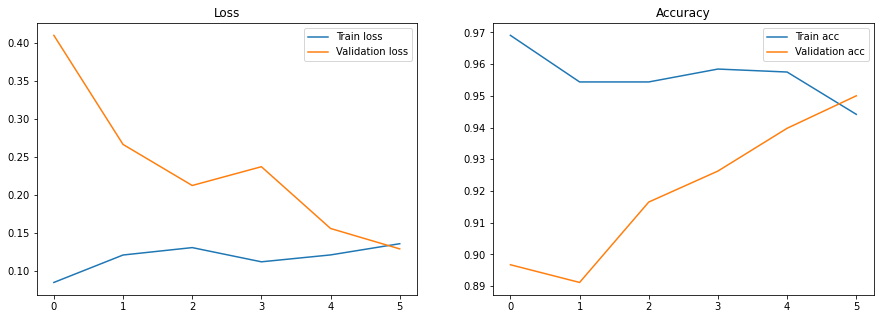

In [180]:
#Not working in this notebook... fix callbacks and repair!
show_final_history(history)
model.load_weights(best_model_weights)
model_eval = model.evaluate(val_ds,steps=100)
print("Model Test Loss:",model_eval[0])
print("Model Test Accuracy:",model_eval[1])

#model_json = model.to_json()
#with open("model.json","w") as json_file:
#    json_file.write(model_json)
    
model.save("model.h5")
print("Weights Saved")

## Now trying to merge transfer learning with own model
my work-in-progress model was predicting my own images as being very cactus like. My idea here was to establish an "if likelihood of this image being cactus is >= x%, then pass it through the mobilenet_v2 model. If something other than window_screen, shower_curtain, prison, window_shade, or crossword_puzzle was predicted, flag the image for inspection.. to see how we could improve the model. However, with improvements, my model was performing well enough that this was fairly moot.

In [52]:
# The following code was borrowed from Metis course material. 
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.preprocessing import image
import numpy as np


#Mobilenet_v2 convolutional neural network/transfer learning model (which was trainined on the ImageNet database).
def prepare_image(img_path): 

    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = mobilenet_v2.preprocess_input(x)
    return x

In [93]:
#This is from the I built model above. 
#here I will bring in my own images to test the binary prediction and the imagenet prediction (below). 
img_path = "/Users/vesper/Documents/Metis/Module_6_Deep_Learning_Neural_Networks/Cactus_Classification_Dataset/test_images/U.jpg"
img = keras.preprocessing.image.load_img(
    "/Users/vesper/Documents/Metis/Module_6_Deep_Learning_Neural_Networks/Cactus_Classification_Dataset/test_images/U.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent likely a cactus and %.2f percent likely non-cactus."
    % (100 * (1 - score), 100 * score)
)

1/1 [==============================] - 0s 19ms/step
This image is 9.65 percent likely a cactus and 90.35 percent likely non-cactus.


In [94]:
#This Instantiates the transfer learning model. The output is the model's predicted classifications, descriptions and score. 

model2 = mobilenet_v2.MobileNetV2(weights='imagenet',)#the "weights" here is where the imagenet transfer learning takes place. I will bring in the cacti training images as one of the next steps (once I learn how to do that appropriately)

x = prepare_image(img_path) 

out = model2.predict(x)

print('Predicted:', mobilenet_v2.decode_predictions(out))

1/1 [==============================] - 1s 632ms/step
Predicted: [[('n03729826', 'matchstick', 0.6840614), ('n04286575', 'spotlight', 0.044102386), ('n03666591', 'lighter', 0.043496188), ('n09472597', 'volcano', 0.019675741), ('n02948072', 'candle', 0.017209671)]]


![test_image](test_images/U.jpg)

### This is now experimenting with dense layers vs the convolution layers I've been using above. 

In [120]:
#try this for a basic kind of comparison
#input_shape=(train_ds.shape[1], 1)
input_shape = (32,32,3)
NN = tf.keras.models.Sequential()
NN.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape = input_shape, activation = 'relu'))
NN.add(tf.keras.layers.Dense(1024, activation = 'relu')) # need feature input dim (28x28) for first hidden layer
#NN.add(tf.keras.layers.Dropout(0.2))
#    model.add(tf.keras.layers.Dense(512))
NN.add(tf.keras.layers.Dense(512, activation = 'relu'))
#NN.add(tf.keras.layers.Dense(256, activation = 'relu'))      
NN.add(tf.keras.layers.Dense(128, activation = 'relu'))
#NN.add(tf.keras.layers.Dense(64, activation = 'relu'))       
NN.add(tf.keras.layers.Dense(32, activation = 'relu'))       
#NN.add(tf.keras.layers.Dense(16, activation = 'relu'))       
#NN.add(tf.keras.layers.Dense(8, activation = 'relu'))       
#NN.add(tf.keras.layers.Dense(4, activation = 'relu'))              
#NN.add(tf.keras.layers.Dense(2, activation = 'relu'))       
NN.add(tf.keras.layers.Flatten())              
NN.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))              

NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
#NN.fit(train_ds, y_train_cat, epochs=20, batch_size=512, verbose=1) # track progress as we fit
NN.fit(train_ds, epochs=2, callbacks=callbacks, validation_data=val_ds,)
#first run, 2 epochs, 7 layers took 10 minutes

Epoch 1/2
538/538 [==============================] - 286s 530ms/step - loss: 0.4328 - accuracy: 0.8735 - val_loss: 0.2534 - val_accuracy: 0.9100
Epoch 2/2
538/538 [==============================] - 312s 580ms/step - loss: 0.2288 - accuracy: 0.9140 - val_loss: 0.1361 - val_accuracy: 0.9484


In [ ]:
input_shape=(X_train.shape[1], 1)